In [3]:
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import PartOfSpeech,MaximalMarginalRelevance,KeyBERTInspired
from sentence_transformers import SentenceTransformer
import joblib
from typing import List, Dict
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch
import json
import scipy
from src.utils import clean_dataset,list_to_dict,convert_ctfidf,NpEncoder

model = SentenceTransformer('all-MiniLM-L6-v2')

/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all')

import re

def load_model(model:int) :
    """Load the corresponding model based on the model number

    Args:
        model (int): ranging from 1 - 4 
    """
    if model == 1 :
        return BERTopic()
    elif model == 2 :
        representation_model = KeyBERTInspired()
        return BERTopic(representation_model=representation_model)
    elif model == 3 :
        representation_model = PartOfSpeech("en_core_web_sm")
        return BERTopic(representation_model=representation_model)
    else : 
        representation_model = MaximalMarginalRelevance(diversity=0.3)
        return BERTopic(representation_model=representation_model)

def clean_text(text):
    # Remove escape sequences
    text = re.sub(r'\\[a-zA-Z]', ' ', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Example usage:
text = "Hello, this is an example text with an email address john@example.com. \nPlease remove punctuation and escape sequences, including \\n."
cleaned_text = clean_text(text)
print(cleaned_text)


from tqdm import tqdm

docs = []
for text in tqdm(newsgroups_train["data"]):
  docs.append(clean_text(text))

Hello this is an example text with an email address Please remove punctuation and escape sequences including


100%|██████████| 18846/18846 [00:01<00:00, 12032.51it/s]


In [3]:
docs = []
count = 0
for text in tqdm(newsgroups_train["data"]):
  count+=1
  docs.append(clean_text(text) + f" c_{count}")

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()



100%|██████████| 18846/18846 [00:01<00:00, 12046.65it/s]
/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6412,-1_to_the_of_and,"[to, the, of, and, for, is, in, from, you, it]",[From Matt Freivald x8043 Subject Re Good Neig...
1,0,388,0_pub_graphics_mail_edu,"[pub, graphics, mail, edu, ftp, 128, siggraph,...",[From Dan Wallach Subject FAQ Typing Injuries ...
2,1,262,1_windows_dos_memory_swap,"[windows, dos, memory, swap, disk, file, emm38...",[From Andrew Tong Subject Re Challenge to Micr...
3,2,189,2_cramer_gay_clayton_sexual,"[cramer, gay, clayton, sexual, homosexual, men...",[From Clayton Cramer Subject Re Median Re New ...
4,3,158,3_image_3d_graphics_phigs,"[image, 3d, graphics, phigs, package, library,...",[From David B Lewis Subject comp windows x Fre...
...,...,...,...,...,...
366,365,11,365_tga_rle_pov_tmp,"[tga, rle, pov, tmp, povray, convert, xloadima...",[Subject Re POVray tga rle From Craig Andrew H...
367,366,11,366_funny_tsk_rahe_newbie,"[funny, tsk, rahe, newbie, ipser, pettefar, te...",[From Pete Young Subject Re For 3 Last Organiz...
368,367,11,367_solar_sail_sails_flexible,"[solar, sail, sails, flexible, project, sunlig...",[From Bill Higgins Beam Jockey Subject Re Sola...
369,368,11,368_freeman_censorship_garfiel_company,"[freeman, censorship, garfiel, company, fraud,...",[From D DANIEL SOKOL Subject Re Enough Freeman...


In [5]:
def centroid_ablation(word:str,document:str) -> float:
    """Take word out from document and see how much document embedding moves. 

    Args:
        word (str): the input word
        document (str): the input document 

    Returns:
        float: the movement of the document embedding. 
    """
    document_embed = model.encode(document, convert_to_tensor=True)
    document_without_word = document.replace(word, "")
    document_without_word_embed = model.encode(document_without_word, convert_to_tensor=True)
    return float(torch.linalg.norm(document_embed-document_without_word_embed))
    
# centroid_ablation("The","The bird is on the tree. The cat is eating the bird.")


def get_spearman_rho(ctf_idf_json_topic1, ctf_idf_json_topic2):
    # print(ctf_idf_json_topic1, ctf_idf_json_topic2)
    words1 = list(ctf_idf_json_topic1.keys())
    ctf_idf_rankings1 = [ctf_idf_json_topic1[word] for word in words1]
    # print(f'Numbers for key {i}: {numbers_for_key}')
    x = ctf_idf_rankings1

    ctf_idf_rankings2 = [ctf_idf_json_topic2[word] for word in words1]
    # print(f'Numbers for key {i}: {numbers_for_key}')
    y = ctf_idf_rankings2
    rho, p_value = scipy.stats.spearmanr(x, y)
    return rho, p_value

def get_kendall_tau(ctf_idf_json_topic1, ctf_idf_json_topic2):
    # print(ctf_idf_json_topic1, ctf_idf_json_topic2)
    words1 = list(ctf_idf_json_topic1.keys())
    ctf_idf_rankings1 = [ctf_idf_json_topic1[word] for word in words1]
    # print(f'Numbers for key {i}: {numbers_for_key}')
    x = ctf_idf_rankings1

    ctf_idf_rankings2 = [ctf_idf_json_topic2[word] for word in words1]
    # print(f'Numbers for key {i}: {numbers_for_key}')
    y = ctf_idf_rankings2
    rho, p_value = scipy.stats.spearmanr(x, y)
    return rho, p_value

In [6]:
def raw_centroid_checks( docs: List[str], k: int, model: int) -> pd.DataFrame:
    """
    Take as input a list of documents, a speicific number of topics to run the check for,
    and the model. 
    1. Run a basic bertopic model to fit_transform the dataset.
    2. For each topic in 1 to k :
        2.1 Remove each repn word. 
        2.2 Check how much on avg the document embeddings change. 
    """
    final_ablation_mappings = {}
    anchor_topic_model = load_model(model)
    topics, probs = anchor_topic_model.fit_transform(docs)
    topic_list = anchor_topic_model.get_topic_info()
    c_tf_idf_mappings = anchor_topic_model.topic_representations_
    c_tf_idf_mappings = convert_ctfidf(c_tf_idf_mappings)

    documents = anchor_topic_model.get_topic_info()["Representative_Docs"]

    df_basic_mapping = pd.DataFrame({"Document": docs, "Topic": topics})

    for topic_i in tqdm(range(k)):
        topic_documents = df_basic_mapping[df_basic_mapping['Topic'] == topic_i]["Document"]
        ablation_mappings = {}
        for word in c_tf_idf_mappings[topic_i].keys():
            centroid_movement = []
            for document in topic_documents :
                centroid_movement.append(centroid_ablation(word,document))
            ablation_mappings[word] = np.mean(centroid_movement)
        final_ablation_mappings[topic_i] = get_kendall_tau(c_tf_idf_mappings[topic_i],ablation_mappings)
    return final_ablation_mappings

# raw_centroid_checks(docs,2,1)

In [7]:
def run_centroid_ablation( docs: List[str], k: int, model: int, repeats: int, save_path: str)->None:
    """_summary_

    Args:
        docs (List[str]): _description_
        k (int): _description_
        model (int): _description_
        repeats (int): _description_
        save_path (str): _description_
    """

    to_save = {}
    for _ in range(repeats) : 
        to_save[_] = raw_centroid_checks(docs,k,model)
    
    with open(save_path, 'w') as json_file:
        json.dump(to_save, json_file)

In [7]:
run_centroid_ablation(docs = docs , k = 100, model = 1, repeats = 1, save_path= "final_result_kendall/centroid/centroid_1.json")

100%|██████████| 100/100 [09:39<00:00,  5.79s/it]


In [8]:
run_centroid_ablation(docs = docs , k = 100, model = 2, repeats = 1, save_path= "final_result_kendall/centroid/centroid_2.json")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [9]:
run_centroid_ablation(docs = docs , k = 100, model = 3, repeats = 1, save_path= "final_result_kendall/centroid/centroid_3.json")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [10]:
run_centroid_ablation(docs = docs , k = 100, model = 4, repeats = 1, save_path= "final_result_kendall/centroid/centroid_4.json")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [8]:
def read_data(path):
    df = pd.read_csv(path)
    return df['text'].tolist()

nyt = read_data("data/nyt2020.csv")
wiki = read_data("data/wiki_en_10000.csv")

In [9]:
run_centroid_ablation(docs = nyt , k = 100, model = 1, repeats = 1, save_path= "final_result/centroid/nyt_centroid_1.json")
run_centroid_ablation(docs = nyt , k = 100, model = 2, repeats = 1, save_path= "final_result/centroid/nyt_centroid_2.json")
run_centroid_ablation(docs = nyt , k = 100, model = 3, repeats = 1, save_path= "final_result/centroid/nyt_centroid_3.json")
run_centroid_ablation(docs = nyt , k = 100, model = 4, repeats = 1, save_path= "final_result/centroid/nyt_centroid_4.json")

/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https

In [10]:
run_centroid_ablation(docs = wiki , k = 100, model = 1, repeats = 1, save_path= "final_result/centroid/wiki_centroid_1.json")
run_centroid_ablation(docs = wiki , k = 100, model = 2, repeats = 1, save_path= "final_result/centroid/wiki_centroid_2.json")
run_centroid_ablation(docs = wiki , k = 100, model = 3, repeats = 1, save_path= "final_result/centroid/wiki_centroid_3.json")
run_centroid_ablation(docs = wiki , k = 100, model = 4, repeats = 1, save_path= "final_result/centroid/wiki_centroid_4.json")

 43%|████▎     | 43/100 [10:46<08:12,  8.64s/it] /home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
  1%|          | 1/100 [01:05<1:47:49, 65.35s/it]/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
 19%|█▉        | 19/100 [06:21<15:32, 11.51s/it] /home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 100/100 [14:53<00:00,  8.94s/it]


In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math

def remove_nan_from_list(float_list):
    return list(filter(lambda x: not math.isnan(x), float_list))

def read_json_and_plot(filename):
    # Read JSON file
    with open(filename, 'r') as file:
        data = json.load(file)
    
    # Extract x and y values
    x_values = []
    y_values = []
    for key in data:
        # Iterate through inner dictionary
        inner_dict = data[key]
        for inner_key in inner_dict:
            x_values.append(inner_dict[inner_key][0])  # First number in each item
            y_values.append(inner_dict[inner_key][1])  # Second number in each item

    # Plot
    # plt.figure(figsize=(8, 6))
    # plt.plot(x_values, y_values, 'bo', label='Data Points')
    # plt.title('Normal Plot')
    # plt.xlabel('X values')
    # plt.ylabel('Y values')
    # plt.grid(True)
    # plt.legend()

    # Calculate mean and standard deviation
    x_values = remove_nan_from_list(x_values)
    y_values = remove_nan_from_list(y_values)
    x_mean = np.mean(x_values)
    y_mean = np.mean(y_values)
    x_std = np.std(x_values)
    y_std = np.std(y_values)
    print(f"Mean of X values: {x_mean}")
    print(f"Mean of Y values: {y_mean}")
    print(f"Standard deviation of X values: {x_std}")
    print(f"Standard deviation of Y values: {y_std}")

    # plt.show()

# Usage
# read_json_and_plot('your_json_file.json')


In [26]:
read_json_and_plot("final_result/centroid/wiki_centroid_1.json")

Mean of X values: 0.06900737276706027
Mean of Y values: 0.39241681400110506
Standard deviation of X values: 0.41942395959733564
Standard deviation of Y values: 0.2952454713213345


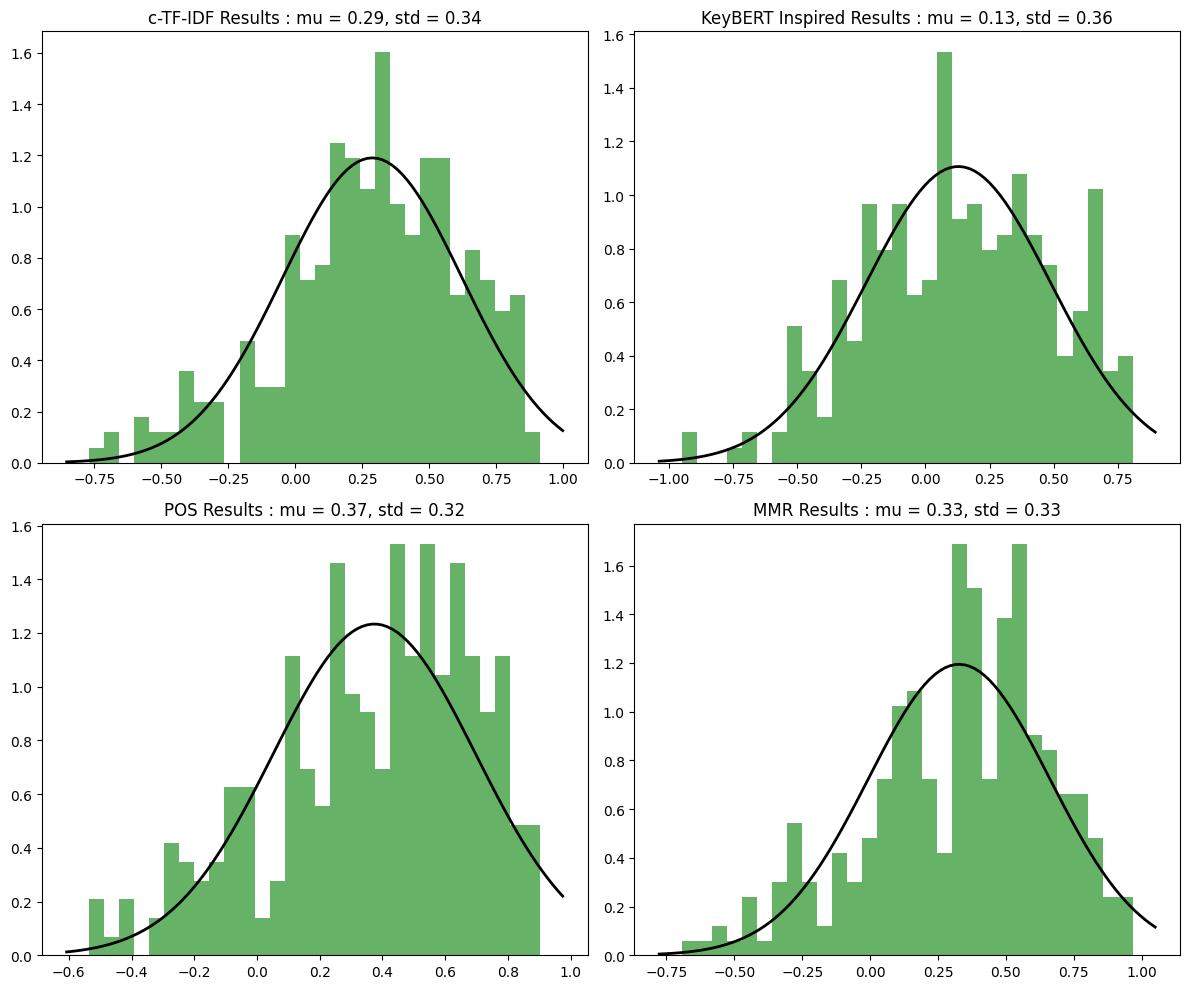

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_gaussian_distributions(filenames):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    model_name_dict = {
        0 : "c-TF-IDF",
        1 : "KeyBERT Inspired",
        2 : "POS",
        3 : "MMR"
    }
    for i, filename in enumerate(filenames):
        # Read JSON file
        with open(filename, 'r') as file:
            data = json.load(file)
        
        # Extract x values
        x_values = []
        for key in data:
            inner_dict = data[key]
            for inner_key in inner_dict:
                x_values.append(inner_dict[inner_key][0])  # First number in each item

        # Plot Gaussian distribution on X values
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        ax.hist(x_values, bins=30, density=True, alpha=0.6, color='g')

        # Fit a normal distribution to the data
        mu, std = np.mean(x_values), np.std(x_values)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2)
        title = f"{model_name_dict[i]} Results : mu = {mu:.2f}, std = {std:.2f}"
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Usage
filenames = ['final_result_kendall/centroid/centroid_1.json', 'final_result_kendall/centroid/centroid_2.json','final_result_kendall/centroid/centroid_3.json','final_result_kendall/centroid/centroid_4.json',]
plot_gaussian_distributions(filenames)
